In [ ]:
%pip install tensorrt

In [1]:
from tensorflow import keras
import os
import io
import gc
import string
import numpy as np
from keras import backend as K
from keras import layers, models
from os import listdir
import random
from tensorflow.keras import losses
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding

2024-05-16 15:36:46.723473: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-16 15:36:50.438894: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def remove_files(dir):
    files = listdir(dir)
    for n, file in enumerate(files):
        os.remove(dir + '/' + file)

In [3]:
def remove_chars_from_text(text, chars):
    return "".join([ch for ch in text if ch in chars])

In [4]:
def clear_text(text):
    enabled_chars = 'абвгдежзийклмнопрстуфхцчшщьыъэюя!?., '
    cleared = text.lower()
    cleared = remove_chars_from_text(cleared, enabled_chars)
    return cleared

In [5]:
input_dir = 'Пушкин'
# remove_files(input_dir + '/.ipynb_checkpoints')
# os.rmdir(input_dir + '/.ipynb_checkpoints')
file_list = listdir(input_dir)
datasets = list()
for n, file in enumerate(file_list[:7]):
    text = ''
    with io.open(input_dir + '/' + file, mode='r', encoding='utf-8') as f:
                try:
                    text = f.read()
                except Exception:
                    print('Can not read file', f)
    datasets.append(text)

In [7]:
X_train_text = [clear_text(text) for text in datasets]

len(X_train_text)

7

In [8]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(char_level=True)

tokenizer.fit_on_texts(X_train_text)

In [9]:
print(tokenizer.word_index)

{' ': 1, 'о': 2, 'е': 3, 'а': 4, 'т': 5, 'и': 6, 'н': 7, 'с': 8, 'л': 9, 'в': 10, 'р': 11, 'д': 12, 'м': 13, 'к': 14, 'у': 15, ',': 16, 'п': 17, 'ь': 18, 'я': 19, 'б': 20, 'г': 21, 'ы': 22, 'з': 23, '.': 24, 'й': 25, 'ч': 26, 'ж': 27, 'ш': 28, 'х': 29, 'ц': 30, 'ю': 31, '?': 32, '!': 33, 'щ': 34, 'э': 35, 'ъ': 36, 'ф': 37}


In [14]:
%%time

seq_length = 20
X_train, Y_train = [], []

for text in X_train_text:
    for i in range(0, len(text) - seq_length):
        inp_seq = text[i:i + seq_length]
        X_train.append(inp_seq)
        out_seq = text[i + seq_length]
        Y_train.append(tokenizer.word_index[out_seq])

X_train = tokenizer.texts_to_sequences(X_train)

X_train, Y_train = np.array(X_train, dtype=np.int32).reshape(-1, seq_length,1), np.array(Y_train)

X_train.shape, Y_train.shape

CPU times: user 604 ms, sys: 11.2 ms, total: 616 ms
Wall time: 613 ms


((80956, 20, 1), (80956,))

In [11]:
def random_idx():
    random.seed(123)
    return random.randint(0, len(X_train))

In [12]:
def get_initial_pattern_by_indx(idx : int):
    return X_train[idx].flatten().tolist()

In [13]:
def get_text_from_indx(idx, array):
    return "".join([tokenizer.index_word[idx] for idx in array]);

In [21]:
def generate_ans():
    ans = ""
    idx = random_idx()
    pattern = get_initial_pattern_by_indx(idx)
    generated_text = []
    ans = ans + "Начальный текст : {}".format("".join([tokenizer.index_word[idx] for idx in pattern]))
    for i in range(100):
        X_batch = np.array(pattern, dtype=np.int32).reshape(1, seq_length)
        preds = model.predict(X_batch)
        predicted_index = preds.argmax(axis=-1)[0]
        generated_text.append(predicted_index)
        pattern.append(predicted_index)
        pattern = pattern[1:]
    ans = ans + "\nСгенерированный текст : {}".format("".join([tokenizer.index_word[idx] for idx in generated_text]))
    print(ans)

In [16]:
gc.collect()

48

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding

embed_len = 20
lstm_out = 256

model = Sequential([
                    Embedding(len(tokenizer.word_index)+1, output_dim=embed_len, input_length=seq_length),
                    LSTM(lstm_out, input_shape=(seq_length, 1), return_sequences=True),
                    LSTM(lstm_out),
                    Dense(len(tokenizer.word_index) + 1, activation="softmax")
                ])

model.summary()

2024-05-16 15:43:45.553909: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79262 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:8c:00.0, compute capability: 8.0
2024-05-16 15:43:46.809605: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-16 15:43:46.812648: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/s

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 20)            760       
                                                                 
 lstm (LSTM)                 (None, 20, 256)           283648    
                                                                 
 lstm_1 (LSTM)               (None, 256)               525312    
                                                                 
 dense (Dense)               (None, 38)                9766      
                                                                 
Total params: 819,486
Trainable params: 819,486
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.compile(optimizer=Adam(learning_rate=0.001), loss="sparse_categorical_crossentropy")

In [19]:
history = model.fit(X_train, Y_train, batch_size=1024, epochs=10)

Epoch 1/10


2024-05-16 15:45:36.236372: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-16 15:45:36.239320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-16 15:45:36.241764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

80/80 [==============================] - 5s 11ms/step - loss: 3.1655
Epoch 2/10
80/80 [==============================] - 1s 6ms/step - loss: 3.1111
Epoch 3/10
80/80 [==============================] - 1s 6ms/step - loss: 2.9956
Epoch 4/10
80/80 [==============================] - 1s 6ms/step - loss: 2.7383
Epoch 5/10
80/80 [==============================] - 1s 8ms/step - loss: 2.5803
Epoch 6/10
80/80 [==============================] - 1s 6ms/step - loss: 2.5172
Epoch 7/10
80/80 [==============================] - 1s 7ms/step - loss: 2.4670
Epoch 8/10
80/80 [==============================] - 1s 7ms/step - loss: 2.4131
Epoch 9/10
80/80 [==============================] - 1s 7ms/step - loss: 2.3594
Epoch 10/10
80/80 [==============================] - 1s 6ms/step - loss: 2.3102


In [22]:
generate_ans()

1/1 [==============================] - 0s 20ms/step
Начальный текст :  любовалась и диву д
Сгенерированный текст : ерет он бела постой пристала в тем постой пристала в тем постой пристала в тем постой пристала в тем


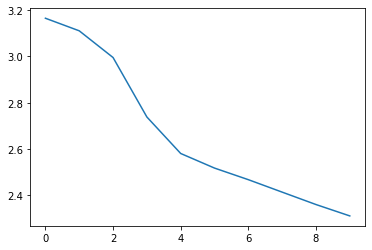

In [23]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.show()

In [24]:
K.set_value(model.optimizer.learning_rate, 0.0003)
history = model.fit(X_train, Y_train, batch_size=1024, epochs=20)

Epoch 1/20
80/80 [==============================] - 1s 7ms/step - loss: 2.2492
Epoch 2/20
80/80 [==============================] - 1s 6ms/step - loss: 2.2257
Epoch 3/20
80/80 [==============================] - 1s 6ms/step - loss: 2.2062
Epoch 4/20
80/80 [==============================] - 1s 8ms/step - loss: 2.1854
Epoch 5/20
80/80 [==============================] - 1s 6ms/step - loss: 2.1646
Epoch 6/20
80/80 [==============================] - 1s 6ms/step - loss: 2.1444
Epoch 7/20
80/80 [==============================] - 1s 6ms/step - loss: 2.1236
Epoch 8/20
80/80 [==============================] - 1s 7ms/step - loss: 2.1048
Epoch 9/20
80/80 [==============================] - 1s 7ms/step - loss: 2.0834
Epoch 10/20
80/80 [==============================] - 1s 6ms/step - loss: 2.0653
Epoch 11/20
80/80 [==============================] - 1s 6ms/step - loss: 2.0448
Epoch 12/20
80/80 [==============================] - 1s 6ms/step - loss: 2.0253
Epoch 13/20
80/80 [==============================

In [25]:
generate_ans()

1/1 [==============================] - 0s 19ms/step
Начальный текст :  любовалась и диву д
Сгенерированный текст : а страта так на свет и в том он и в свете же свет и сам то стол он с нам и в том он тебе долодой при


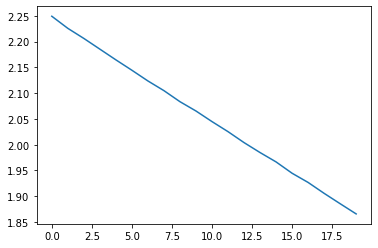

In [26]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.show()

In [27]:
K.set_value(model.optimizer.learning_rate, 0.0001)
history = model.fit(X_train, Y_train, batch_size=1024, epochs=20)

Epoch 1/20
80/80 [==============================] - 1s 7ms/step - loss: 1.8351
Epoch 2/20
80/80 [==============================] - 1s 7ms/step - loss: 1.8253
Epoch 3/20
80/80 [==============================] - 1s 6ms/step - loss: 1.8176
Epoch 4/20
80/80 [==============================] - 1s 6ms/step - loss: 1.8105
Epoch 5/20
80/80 [==============================] - 1s 7ms/step - loss: 1.8026
Epoch 6/20
80/80 [==============================] - 1s 7ms/step - loss: 1.7950
Epoch 7/20
80/80 [==============================] - 1s 7ms/step - loss: 1.7881
Epoch 8/20
80/80 [==============================] - 1s 7ms/step - loss: 1.7806
Epoch 9/20
80/80 [==============================] - 1s 7ms/step - loss: 1.7735
Epoch 10/20
80/80 [==============================] - 1s 6ms/step - loss: 1.7658
Epoch 11/20
80/80 [==============================] - 1s 7ms/step - loss: 1.7589
Epoch 12/20
80/80 [==============================] - 1s 7ms/step - loss: 1.7513
Epoch 13/20
80/80 [==============================

In [28]:
generate_ans()

1/1 [==============================] - 0s 20ms/step
Начальный текст :  любовалась и диву д
Сгенерированный текст : а страва стол он с ним и в том тем свет и в том он с слатом богостить, с нам он в гости он и слашит 


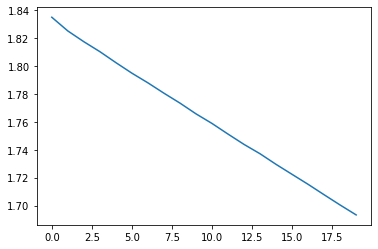

In [29]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.show()

In [27]:
model.save('models/onlyPuskin.keras')